# Twitter Analysis on Marijuana
**Guru Prasad - A20344932**

In [1]:
from StringIO import StringIO
import json
import urllib2
import re
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import hashlib
import numpy as np
import csv
from datetime import datetime, timedelta
import pymongo
from pymongo import MongoClient
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import pickle
from sklearn import neighbors
from zipfile import ZipFile
from sklearn import svm
from pylab import *

**Collect data from the MongoDB**

In [2]:
#Collect the data stored during data collection in MongDB. The client ip address is 192.168.1.124 and port number is 27017
#There is no need to run this part of code 
if False:
    client = MongoClient('192.168.1.124', 27017)
    db = client.test_database


    tweetDB=[]
    x=[str(x) for x in db.collection_names() if str(x)!='system.indexes']
    tweetDB=[db.get_collection(i) for i in x]




    allTweet=[]
    for i in tweetDB:
        c=tweetDB[1].find()
        for i in c:
            allTweet.append(i)

**Remove non unicode characters from Tweets before writing it into the file**

In [3]:
if False:
    def unicode_text(text):
        string = re.sub('http\S+', 'THIS_IS_A_URL', text)
        tokens = re.findall(r"\w+", string.lower(),flags = re.L)
        tokens1 = []
        for i in tokens:
            x = re.findall(r"\w+", i,flags = re.U)
            for j in x:
                tokens1.append(j)
        return " ".join(tokens1)

**Call the unicode_text function to remove non ascii charaters from tweets,description and user name**

In [4]:
if False:
    for json in allTweet:
        json['text'] = unicode_text(json['text'])
        json['user']['description'] = unicode_text(json['user']['description'])
        json['user']['name']=unicode_text(json['user']['name'])

In [5]:
if False:
    tweets = {}
    location = {}
    user_name = {} 
    description ={}
    hastags = {}
    for i in allTweet:
        hashtag = []
        tweet = []
        if i['user']['screen_name'] in tweets.keys():
            tweets[i['user']['screen_name']].append(i['text'])
        else:
            tweets[i['user']['screen_name']]= [i['text']]
        location[i['user']['screen_name']] = [i['user']['location']]
        user_name[i['user']['screen_name']]= i['user']['name']
        for j in i['entities']['hashtags']:
            hashtag.append(j['text'])
        hastags[i['user']['screen_name']]=hashtag
        description[i['user']['screen_name']] =[i['user']['description']]

**Extracting the required data from JSON**

In [6]:
#Extract the required data for analysis for the JSON to a list to store it in a csv file
if False:
    data = []
    for json in allTweet:
        tweet_data = []
        tweet_data.append(json['user']['screen_name'])
        tweet_data.append(json['user']['description'])
        tweet_data.append(json['text'])
        tweet_data.append(json['user']['name'])
        data.append(tweet_data)

**Write the Data to CSV file**

In [7]:
if False:
    with open('twitter_data.csv', 'w') as fp:
        a = csv.writer(fp)
        a.writerows(data)

In [8]:
if False:
    tweet_manual_labelling = []
    for i in tweet_test:
        if i.split()[0] != 'rt':
            tweet_manual_labelling.append((1,i))
    with open('tweet_manual_labelling.csv', 'w') as fp1:
        filewriter = csv.writer(fp1)
        filewriter.writerows(tweet_manual_labelling)

**Read Tweets and User name from the csv file**

In [9]:
def read_tweets(filename):
    tweet_t = []
    user_n = []
    with open(filename, 'rb') as csvfile:
        filereader = csv.reader(csvfile)
        for  row in filereader:
            tweet_t.append(row[2])
            user_n.append(row[3])
    return tweet_t,user_n

In [10]:
tweet_test, user_name = read_tweets('twitter_data.csv')

**Read Manually labled data from CSV file for training**

In [11]:
def read_tarining_data(filename):
    labeled_tweets = []
    labels1 = []
    with open(filename, 'rb') as csvfile1:
        filereader = csv.reader(csvfile1)
        for  row in filereader:
            labeled_tweets.append(row[1])
            labels1.append(int(row[0]))
    return labeled_tweets,np.array(labels1)

In [12]:
labeled_tweets,labels = read_tarining_data('tweet_manual_labelling.csv')

**Tokenizing Function**

In [13]:
def tokenize(text):
    tokens = re.findall(r"\w+|\S", text.lower(),flags = re.L)
    tokens1 = []
    for i in tokens:
        x = re.findall(r"\w+|\S", i,flags = re.U)
        for j in x:
            tokens1.append(j)
            
    return tokens1


**Vectorizer**

In [14]:
#To convert the tweets into CSR matrix we use this vectorizer fucnction with min_df =1,max_df = 1.,ngram = (1,1) and binary = true
def do_vectorize(tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):

    lis = ['weed','marijuana','pot','cannabis']#list of stop words
    #countvectorizer object
    vectorizer = CountVectorizer(input = 'content', tokenizer = tokenizer_fn, min_df=min_df, 
                                     max_df=max_df, binary=binary, ngram_range=ngram_range,
                                 dtype = 'int',analyzer='word',token_pattern='(?u)\b\w\w+\b',encoding='utf-8' )
    return vectorizer

**Train Using the manually labled data**

In [15]:
vectorizer = do_vectorize() #get the vectorizer object
matrix = vectorizer.fit_transform(t for t in labeled_tweets) # learn new words and tranform it to a CSR matrix
print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))

matrix represents 290 documents with 1842 features
first doc has terms:
[117, 157, 166, 312, 382, 496, 774, 1023, 1025, 1057, 1202, 1357, 1454, 1533, 1543, 1585]


**Shuffle the trained data **

In [16]:
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:

            yield ord(c)

def repeatable_shuffle(X, y, labeled_tweets):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(labeled_tweets)[indices]

X, y, twittertweets = repeatable_shuffle(matrix, labels, labeled_tweets)

print('fourth shuffled document %s has label %d and terms: %s' % 
      (twittertweets[4], y[4], sorted(X[4].nonzero()[1])))

fourth shuffled document davedtc thanks for the follow we love napa nothing like paring a great wine with an awesome cannabis strain has label 1 and terms: [92, 137, 191, 312, 457, 623, 625, 696, 937, 954, 1091, 1123, 1208, 1511, 1565, 1569, 1727, 1772, 1774]


**Logistic Regression Classifier**

In [17]:
def get_clf(C = 1.,penalty = 'l2'):
    return LogisticRegression(C = C,penalty=penalty,random_state=42)
clf_logistic = get_clf()

**LinearSVC Classifier**

In [18]:
def get_clf_SVC(C = 1.,penalty = 'l2'):
    return LinearSVC(C = C,penalty=penalty,random_state=42)
clf_lSVC = get_clf_SVC()

**K-Fold cross validation to test the accuracy of prediction model**

In [19]:
def do_cross_validation(X, y,clf, n_folds=5):
    cv = KFold(len(y), n_folds)
    accuracies = []
    for train_ind, test_ind in cv: 
        clf.fit(X[train_ind], y[train_ind])
        predictions = clf.predict(X[test_ind])
        accuracies.append(accuracy_score(y[test_ind], predictions))
    avg = np.mean(accuracies)
    return avg

In [20]:
logistic_regression_accuracy = (do_cross_validation(X, y,clf_logistic))*100
print('Average cross validation accuracy for Logistic Regression=%.1f percentage' % (logistic_regression_accuracy))

Average cross validation accuracy for Logistic Regression=78.3 percentage


In [21]:
linear_regression_accuracy=(do_cross_validation(X, y,clf_lSVC)*100)
print('Average cross validation accuracy for LinearSVC=%.1f percentage' % (linear_regression_accuracy))

Average cross validation accuracy for LinearSVC=73.8 percentage


**Experimenting Validation accuracy on different values of C**

In [22]:
#Assuming different values of C for experiment
C_list = [0.1,1.0,10.,50.,100.]
lr_acr = []
ls_acr = []
for i in C_list:
    clf_logistic1 = get_clf(C=i)
    clf_lSVC1 = get_clf_SVC(C=i)
    lr_acr.append(do_cross_validation(X, y,clf_logistic1)*100)
    ls_acr.append(do_cross_validation(X, y,clf_lSVC)*100)
print "C\tLogistic_Regression\tLinearSVC"
for i in range(len(C_list)):
    print "%.1f\t%.1f\t\t\t%.1f" %(C_list[i],lr_acr[i],ls_acr[i])

C	Logistic_Regression	LinearSVC
0.1	77.6			73.8
1.0	78.3			73.8
10.0	76.2			73.8
50.0	75.9			73.8
100.0	75.9			73.8


**Predict Function for unlabelled Tweets**

In [23]:
def prediction(CLF,trained_CSR,trained_label,untrained_tweets_CSR):
    CLF.fit(trained_CSR,trained_label)
    predicted = CLF.predict(untrained_tweets_CSR)
    return predicted

**Fit and transform the training data and only tranform the testing data for prediction**

In [24]:
vec = do_vectorize()
X = vec.fit_transform(x for x in twittertweets)
test_tweet_vector = vec.transform(t for t in tweet_test)

**Prediction of unlabelled tweets using both classifiers**

In [25]:
Tweet_predicted_logistic =prediction(clf_logistic,X,y,test_tweet_vector)
Tweet_predicted_linearSVC=prediction(clf_lSVC,X,y,test_tweet_vector)

**Results of Predicting the Data**

In [26]:
logitic_pred_dict = dict(Counter(Tweet_predicted_logistic))
linearsvc_pred_dict = dict(Counter(Tweet_predicted_linearSVC))
def print_results(dictionary):
    for i in dictionary:
        if i == -1:
            print "\tTweets aganist marijuana\t\t%d" %dictionary[i]
        elif i == 0:
            print "\tNeutral tweets on marijuana\t\t%d" %dictionary[i]
        elif i == 1:
            print "\tPro marijuana tweets\t\t\t%d" %dictionary[i]
        elif i == 2:
            print "\tTweets supporting its Medical use\t%d" %dictionary[i]

In [27]:
print "Logistic Regression Results"
print_results(logitic_pred_dict)

Logistic Regression Results
	Neutral tweets on marijuana		936
	Pro marijuana tweets			5632
	Tweets supporting its Medical use	1960
	Tweets aganist marijuana		928


In [28]:
print "LinearSVC Results"
print_results(linearsvc_pred_dict)

LinearSVC Results
	Neutral tweets on marijuana		1272
	Pro marijuana tweets			5248
	Tweets supporting its Medical use	1936
	Tweets aganist marijuana		1000


**Finding the percentage of tweets in each category**

In [29]:
def percentage_tweets(dictionary):
    sumt = sum(dictionary.values())
    percentage = {}
    for i in dictionary:
        pr = (dictionary[i]*1.0/sumt)*100
        percentage[i] = pr
    return percentage

In [30]:
logistic_precentage = percentage_tweets(logitic_pred_dict)
linearsvc_percentage = percentage_tweets(linearsvc_pred_dict)

In [31]:
def print_results_percentage(dictionary):
    for i in dictionary:
        if i == -1:
            print "\tTweets aganist marijuana\t\t%.1f percentage" %dictionary[i]
        elif i == 0:
            print "\tNeutral tweets on marijuana\t\t%.1f percentage" %dictionary[i]
        elif i == 1:
            print "\tPro marijuana tweets\t\t\t%.1f percentage" %dictionary[i]
        elif i == 2:
            print "\tTweets supporting its Medical use\t%.1f percentage" %dictionary[i]

In [32]:
print "Logistic Regression Percentage"
print_results_percentage(logistic_precentage)
print "LinearSVC Percentage"
print_results_percentage(linearsvc_percentage)

Logistic Regression Percentage
	Neutral tweets on marijuana		9.9 percentage
	Pro marijuana tweets			59.6 percentage
	Tweets supporting its Medical use	20.7 percentage
	Tweets aganist marijuana		9.8 percentage
LinearSVC Percentage
	Neutral tweets on marijuana		13.5 percentage
	Pro marijuana tweets			55.5 percentage
	Tweets supporting its Medical use	20.5 percentage
	Tweets aganist marijuana		10.6 percentage


**Split users based on their tweet sentiments**

In [33]:
def user_sentiment(user_name,Tweet_predicted):
    user_senti = {}
    for i in  Counter(zip(user_name,Tweet_predicted)):
        if i[1] in user_senti:
            user_senti[i[1]].append(i[0])
        else:
            user_senti[i[1]] = [i[0]]
    user_sentiment_count =  dict(Counter(zip(user_name,Tweet_predicted)))
    for i in user_senti:
        seti = set(user_senti[i])
        for j in user_senti:
            setj = set(user_senti[j])
            if i != j:
                common = list(seti & setj)
                for name in common:
                    if user_sentiment_count[(name,i)] > user_sentiment_count[(name,j)]:
                        if name in user_senti[j]:
                            user_senti[j].remove(name)
    return user_senti

In [34]:
user_sentiment_logistic = user_sentiment(user_name,Tweet_predicted_logistic)
user_sentiment_linearsvc = user_sentiment(user_name,Tweet_predicted_linearSVC)

**Find the percentage of user in each category of tweets**

In [35]:
def user_sentiment_percentage(dictionary):
    user_senti_per = {}
    a = dictionary.keys()
    b = [len(dictionary[i]) for i in a]
    total = sum(b)
    for i in range(len(a)):
        per = ((1.*b[i])/total)*100
        user_senti_per[a[i]] = per
    return user_senti_per

In [36]:
user_sentiment_logistic_per = user_sentiment_percentage(user_sentiment_logistic)
user_sentiment_linearsvc_per = user_sentiment_percentage(user_sentiment_linearsvc)

In [37]:
def print_graph(title,dictionary):
    a = dictionary.keys()
    senti = []
    y = [i for i in range(len(a))]
    for x in a:
        if x == -1:
            senti.append('Against')
        elif x == 0:
            senti.append('Neutral')
        elif x == 1:
            senti.append('Pro')
        elif x == 2:
            senti.append('Medicinal')
    values = [dictionary[i] for i in a]

    plt.bar(y,values, align='center')
    plt.xticks(y, senti)
    plt.title(title)
    plt.show()

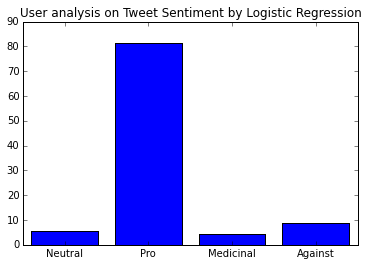

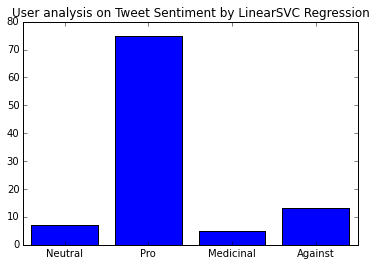

In [38]:
print_graph('User analysis on Tweet Sentiment by Logistic Regression',user_sentiment_logistic_per)
print_graph('User analysis on Tweet Sentiment by LinearSVC Regression',user_sentiment_linearsvc_per)

**Find the ethinicity of the users by user's last name**

In [39]:
ethnicities = {'hispanic':0, 'black':1, 'white':2, 'indians':3, 'asian_pacific_islander':4}

**Scrape data from mongobay website and obtain first 1000 ranks of each ethnicity**

In [40]:
if False:
    def scrape():

        f = open('names.csv', 'w')
        f.write('name,type,rank\n')
        for ethnicity in ethnicities.keys():
            url = "http://names.mongabay.com/data/"+ethnicity+".html"
            request = urllib2.Request(url,headers={'User-Agent' : "Magic Browser"})
            opener = urllib2.build_opener()
            data = opener.open(request).read()
            data = data[data.find('<tr><td>1</td>'):]
            data = data[:data.find('Compiled by <a itemprop=')]
            for i in range(1,1001):
                data = data[data.find('>' + str(i) + '</td>') + 7:]
                f.write(data[data.find('td') + 3: data.find('</td>')].lower() + "," + ethnicity + "," + str(i))
                f.write('\n')
                data = data[20:]
        f.close()

    scrape()

**Train the data from names.csv and prdict the ethnicity based on the last name**

In [41]:
def wordToBinary(word, weight=1):
    arrDict = []
    for i in range(int(ord('a')), int(ord('z') + 1)):
        arrDict += [int(word.count(chr(i))) * weight]
    return arrDict

data = pd.read_csv('names.csv')
train = []
target = []
for index, row in data.iterrows():
    name = row['name']
    if isinstance(name, str) and row['type'] in ethnicities.keys():
        train += [wordToBinary(name, 1 - (1000 - int(row['rank'])) / 1000.0 * 0.2)]
        target += [ethnicities[row['type']]]

assert(len(train) == len(target))

X = np.array(train)
y = np.array(target)
clf = neighbors.KNeighborsClassifier(20, weights='distance')
clf.fit(X, y)
with open('K-neighbor.txt', 'wb') as output:
    pickle.dump(clf, output, pickle.HIGHEST_PROTOCOL)

In [42]:
clf = None
with open('K-neighbor.txt', 'rb') as input:
    clf = pickle.load(input)


def predict(name):
    result = clf.predict([wordToBinary(name)])
    for race, value in ethnicities.iteritems():
        if value == result[0]:
            return race
dicteth={}
lt=[]
last=[]
for label in user_sentiment_logistic:
    for i in user_sentiment_logistic[label]:
        name=i.split()
        if len(name) > 1:
            fname=name[0]
            lname=name[1]
            if lname:
                predicted=predict(lname)
                lt.append(predicted)
                dicteth[i]=predicted
ctr= Counter(lt)

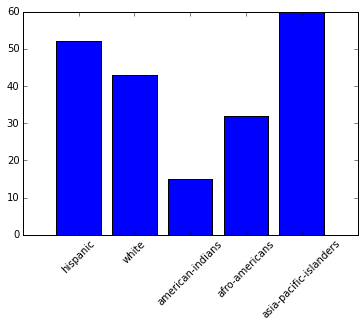

In [43]:
import pylab as plt

a= range(5)
b = ctr.values()
LABELS = ["hispanic","white","american-indians","afro-americans","asia-pacific-islanders"]

plt.bar(a,b, align='center')
plt.xticks(a, LABELS)
plt.xticks(a,rotation = '45')
plt.show()

**Find the gender of user based on the names in the zip file**

In [44]:
zf=ZipFile('names.zip', 'r')
filenames=zf.namelist()

names=dict()
genderMap={'M':0,'F':1}
male_names_dict ={}
female_names_dict ={}
for filename in filenames:
    file=zf.open(filename,'r')
    rows=csv.reader(file, delimiter=',')
    for row in rows:
        gender=genderMap[row[1]]
        if gender == 0:
            name=row[0].lower()
            count=int(row[2])
            male_names_dict[name] = count
        elif gender == 1:
            name=row[0].lower()
            count=int(row[2])
            female_names_dict[name] = count   

    file.close()

In [45]:
def gender_by_name(user_name, male_names, female_names):
    gender_list = []
    for name in user_name:
        if name:
            first = name.split()[0].lower()
            if first in male_names:
                gender_list.append((name,'male'))
            elif first in female_names:
                gender_list.append((name,'female'))
            else:
                gender_list.append((name,'unknown'))
    return gender_list
gender_list = gender_by_name(user_name, male_names_dict, female_names_dict)

In [46]:
male = []
female = []
unknown = []
for i in Counter(gender_list).keys():
    if i[1] == 'male':
        male.append(i[0])
    elif i[1] == 'female':
        female.append(i[0])
    elif i[1] == 'unknown':
        unknown.append(i[0])

**Find the percentage of users based on gender**

In [47]:
total_gender = len(male+female+unknown)
genderpercentage = []
genderpercentage.append((1.*len(male)/total_gender)*100)
print "Percentage of male tweets\t\t%.2f" %((1.*len(male)/total_gender)*100)
genderpercentage.append((1.*len(female)/total_gender)*100)
print "Percentage of female tweets\t\t%.2f" %((1.*len(female)/total_gender)*100)
genderpercentage.append((1.*len(unknown)/total_gender)*100)
print "Percentage of tweets from unknown\t%.2f" %((1.*len(unknown)/total_gender)*100)

Percentage of male tweets		34.23
Percentage of female tweets		6.04
Percentage of tweets from unknown	59.73


**Segregate the user's gender on their sentiments**

In [48]:
def user_sentiment_gender(user_sentiment):
    user_sentiment_count = {}
    for i in user_sentiment:
        count_list = []
        mc = 0 
        fc = 0
        uc = 0
        for j in user_sentiment[i]:
            if j in male:
                mc = mc + 1
            elif j in female:
                fc = fc+1
            elif j in unknown:
                uc = uc + 1
        count_list.append(mc)
        count_list.append(fc)
        count_list.append(uc)
        user_sentiment_count[i] = count_list
    return user_sentiment_count
user_sentiment_count = user_sentiment_gender(user_sentiment_logistic)

In [49]:
user_sentiment_percentage ={}
for i in user_sentiment_count:
    total = 1.*sum(user_sentiment_count[i])
    per_list = []
    for j in user_sentiment_count[i]:
        per = (1.*j/total)*100
        per_list.append(per)
    user_sentiment_percentage[i] = per_list

In [50]:
def print_piechart(key,value):
    figure(1, figsize=(8,8))
    ax = axes([0.1, 0.1, 0.5, 0.5])
    labels = ['Male', 'Female', 'Unknown']
    if key == -1:
        title1 = 'Tweets Aganist Marijuana'
    elif key == 0:
        title1 = 'Neutral Sentiment Tweets on Marijuana'
    elif key == 1:
        title1 = 'Pro Marijuana Tweets'
    elif key == 2:
        title1 = 'Tweets Supporting its Medinical Use'
    title(title1, bbox={'facecolor':'0.8', 'pad':5})
    explode = [0.1]*len(labels)
    pie(value,explode = explode,labels=labels,
                autopct='%1.1f%%', shadow=True, startangle=90)
    show()

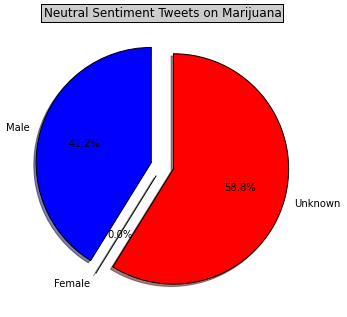

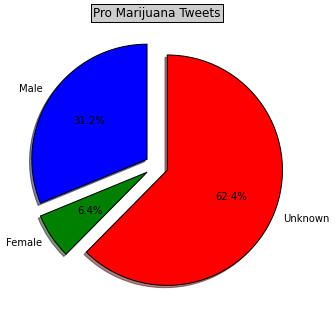

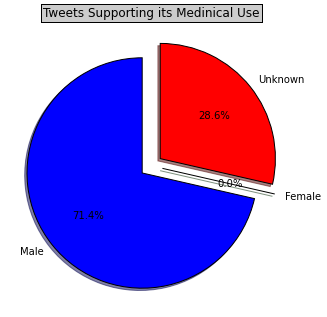

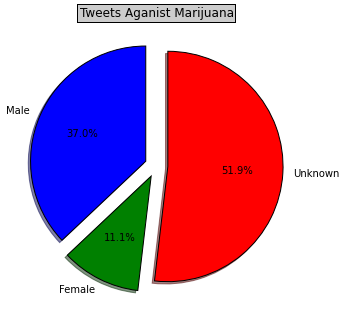

In [51]:
for i in user_sentiment_percentage:
    print_piechart(i,user_sentiment_percentage[i])

In [52]:
import json
outf = open('output.txt', 'wt')
json.dump({
           'total_tweets': len(tweet_test),
           'logistic_regression_accuracy': logistic_regression_accuracy,
           'linear_regression_accuracy': linear_regression_accuracy,
           'Logistic Regression Results':logitic_pred_dict,
           'LinearSVC Results':linearsvc_pred_dict,
            'Logistic Regression Percentage': logistic_precentage,
            'LinearSVC Percentage':linearsvc_percentage,
            'pecenatge_user_each_sentiment_logistic':user_sentiment_logistic_per,
            'pecenatge_user_each_sentiment_linearSVC':user_sentiment_linearsvc_per,
            'percentage_from_each_gender(male,female,unknown)':genderpercentage,
            'percentage_from_each_gender_each_sentiment(male,female,unknown)':user_sentiment_percentage
          },
          outf, indent=2, sort_keys=True)
outf.close()